*Created by Daniel Klöck on April 2020*

# Task

This project generates realistic looking 256x256x3 hands with a DCGAN using the 11K hands dataset as input.

# References

Losely based on

1. [DCGAN256 by t0nberryking](https://github.com/t0nberryking/DCGAN256)
1. [DCGAN256 by manicman1999](https://github.com/manicman1999/GAN256) 
1. [DCGAN image generator by gsurma](https://github.com/gsurma/image_generator)
1. [Tensorflow DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan)
1. [Tensorflow Image Preprocessing](https://keras.io/preprocessing/image/)
1. [Dataset](https://sites.google.com/view/11khands): Mahmoud Afifi, "11K Hands: Gender recognition and biometric identification using a large dataset of hand images." Multimedia Tools and Applications, 2019.
1. [Medium: 10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
1. [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
1. [Medium - GAN — Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)
1. [Medium - Generating High-Resolution Images Using Deep Autoregressive Models](https://towardsdatascience.com/generating-high-resolution-images-using-autoregressive-models-3683f9af0db4)


# Imports

In [3]:
import zipfile
import glob
import os
import time

import matplotlib.pyplot as plt
from PIL import Image 
from IPython import display
import imageio

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths

In [0]:
drive_path = '/content/drive'
real_dir = '/content/real'
initial_zip = '/content/drive/My Drive/AI/Hands.zip'
cleaned_zip = '/content/drive/My Drive/AI/Hands_small.zip'
images_path = real_dir + '/Hands'
images_path_from_cleaned = real_dir + '/content/real/Hands'
out_images_path = '/content/drive/My Drive/AI/images/hands'
checkpoint_dir = '/content/drive/My Drive/AI/checkpoints'

# Hyperparameters

In [0]:
BATCH_SIZE = 128
TARGET_SIZE = (256, 256)

# Should be true on the first run to perform all image preparation actions
IS_FIRST_TIME = False 

# Prepare the images

`Hands.zip` from [6] has been saved in a Google Drive under `/AI/Hands.zip` to serve as the real images.

In [4]:
# Mount the drive
from google.colab import drive
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image preparation

### Extraction

In [0]:
if IS_FIRST_TIME:
    with zipfile.ZipFile(initial_zip, 'r') as zip_ref:
        zip_ref.extractall(real_dir)

To make the generation a bit faster, The images will be cropped and resized to achive a size of 256x256

In [0]:
if IS_FIRST_TIME:
    real_image_paths = list(glob.glob(images_path + '/*'))

In [0]:
if IS_FIRST_TIME:
    for im_path in real_image_paths:
        with Image.open(im_path) as im:
            width, height = im.size 
            if width != 1600 or height != 1200:
                print("{} had an unexpected resolution of {}x{}".format(im_path, width, height))
                continue

            left = width/8
            top = 0
            right = 7*width/8
            bottom = height

            # Crop the image on the sides to achieve a resolution of 1200x1200  
            im = im.crop((left, top, right, bottom))

            # Resize to 256x256
            im = im.resize(TARGET_SIZE)

            # Overwrite original
            im.save(im_path)

Save the transformed files as a zip in the drive

In [0]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

In [0]:
# Save the new version to drive in case we want to load it again
if IS_FIRST_TIME:
    zipf = zipfile.ZipFile(cleaned_zip, 'w', zipfile.ZIP_DEFLATED)
    zipdir(images_path, zipf)
    zipf.close()

# Retrieve the transformed images from the drive

### Extract

In [0]:
if not IS_FIRST_TIME:
    with zipfile.ZipFile(cleaned_zip, 'r') as zip_ref:
        zip_ref.extractall(real_dir)

In [0]:
if not IS_FIRST_TIME:
    real_image_paths = list(glob.glob(images_path_from_cleaned + '/*'))

# Make sure the images have been loaded correctly

In [12]:
print("The dataset consists of {} 256x256 jpg samples".format(len(real_image_paths)))

The dataset consists of 11076 256x256 jpg samples


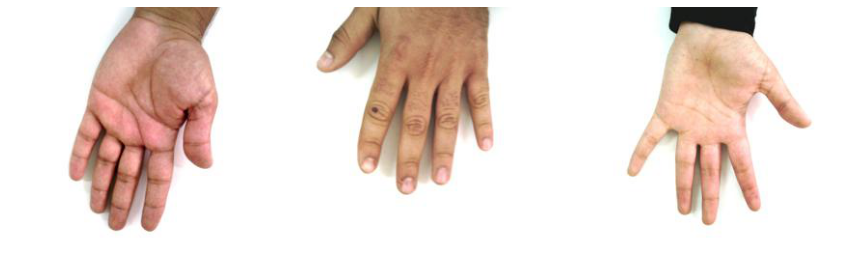

In [13]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Image.open(real_image_paths[i]))
    plt.axis('off')

## Create the ImageDataGenerator for the real images

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing function to change the rangevalue space of 
# the image to [-1, 1] as proposed by [8][9]
def changeRange(image):
    return [(i/128.0)-1 for i in image[:, :, :]]

# For more information see [5]
image_generator = ImageDataGenerator(
    preprocessing_function=changeRange,
    horizontal_flip = True,
    vertical_flip = True)

real_generator = image_generator.flow_from_directory(real_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=TARGET_SIZE,
                                                     class_mode='input')

Found 11076 images belonging to 1 classes.


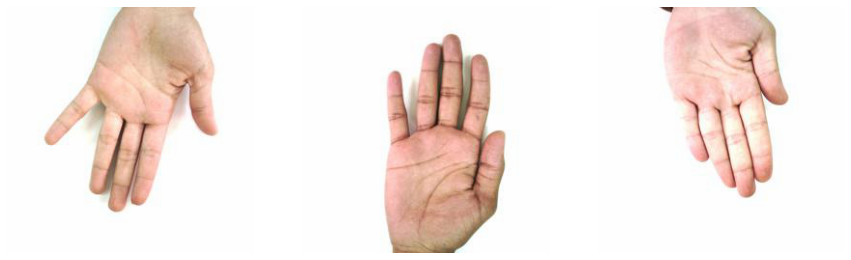

In [15]:
x,y = real_generator.next()
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow((x[i]+1)/2)
    plt.axis('off')

# Generator

Defines the generation based on [1] & [2], but with `tanh` as final activation function as proposed by [8] and adapted to tensorflow2 as discribed in [4]

In [0]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
    assert model.output_shape == (None, 1, 1, 4096)
        
    model.add(layers.Conv2DTranspose(filters = 256, kernel_size = 4))
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 4, 4, 256)
    
    model.add(layers.Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 8, 8, 256)
    
    model.add(layers.Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 16, 16, 128)
    
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 32, 32, 64)
    
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 64, 64, 32)
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 128, 128, 16)
    
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 256, 256, 8)
    
    model.add(layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 256, 256, 3)
    
    return model

In [ ]:
# declares the generator
generator = generator_model()

Displays an example output of the untrained generator

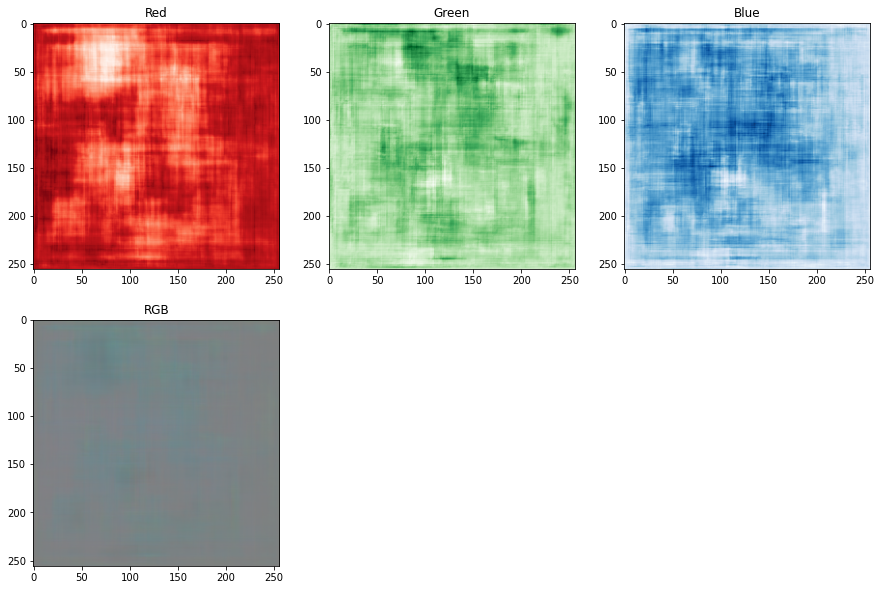

In [17]:
noise = tf.random.normal([1, 4096])
generated_image = generator(noise, training=False)

# show output of untrained generator
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.title("Red")
plt.imshow((generated_image[0, :, :, 0] + 1)/2, cmap='Reds')
plt.subplot(2, 3, 2)
plt.title("Green")
plt.imshow((generated_image[0, :, :, 1] + 1)/2, cmap='Greens')
plt.subplot(2, 3, 3)
plt.title("Blue")
plt.imshow((generated_image[0, :, :, 2] + 1)/2, cmap='Blues')
plt.subplot(2, 3, 4)
plt.title("RGB")
plt.imshow((generated_image[0, :, :, :] + 1)/2)

# Discriminator

Defines the discriminator based on [1] & [2], but adapted to tensorflow2 and partially changed as discribed in [4].

In [0]:
def discriminator_model():
    model = tf.keras.Sequential()
        
    #add Gaussian noise to prevent Discriminator overfitting
    model.add(layers.GaussianNoise(0.2, input_shape = [256, 256, 3]))
    
    #256x256x3 Image
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #128x128x8
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #64x64x16
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #32x32x32
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #16x16x64
    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #8x8x128
    model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #4x4x256
    model.add(layers.Flatten())
    
    #256
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    return model

In [0]:
# Declares the discriminator
discriminator = discriminator_model()

# Define loss & optimizers

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss & optimizer

The discriminator's loss quantifies how good it can distinguish between real and fake images

In [0]:
def discriminator_loss(real_output, fake_output):
    # [8][9] Using soft labels
    real_values = np.random.uniform(0.95, 1.0, size = real_output.get_shape())
    fake_values = np.random.uniform(0.0, 0.05, size = fake_output.get_shape())

    real_loss = cross_entropy(real_values, real_output)
    fake_loss = cross_entropy(fake_values, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

## Generator loss & optimizer

The more the fake output images of the generator are accepted by the discriminator as real images, the lower it's loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)

# Save Checkpoints

The training will surely be running for a while and Colab likes to disconnect from time to time, therefore saving the checkpoints is a must.

In [0]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# Define the training loop

In [0]:
noise_dim = 4096
num_examples_to_generate = 9

# Generate seeded noise to make the evolution more visible in the gif
seed = tf.random.normal([num_examples_to_generate, noise_dim])

A compiled training step, which claculates the losses and applies gradients to the models

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

The training loop, which executes a training step for each epoch/batch, saves the newly generated image and also creates a checkpoint every 10 epochs.  

In [0]:
def train(dataset, start_epoch, epochs):
    for epoch in range(start_epoch, start_epoch + epochs):
        start = time.time()
        
        batches = 0
        for image_batch in dataset:
            print(".", end = '')
            train_step(image_batch)

            # The loop needs to be broken manually, since a generator is being
            # used and it loops indefinitely
            batches += 1
            if batches >= len(real_image_paths) / BATCH_SIZE:
                break

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Generate and save images

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow((predictions[i, :, :, :] + 1)/2)
        plt.axis('off')

    plt.savefig(out_images_path + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Restore latest checkpoins


In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # make sure drive is mounted

# Train the model

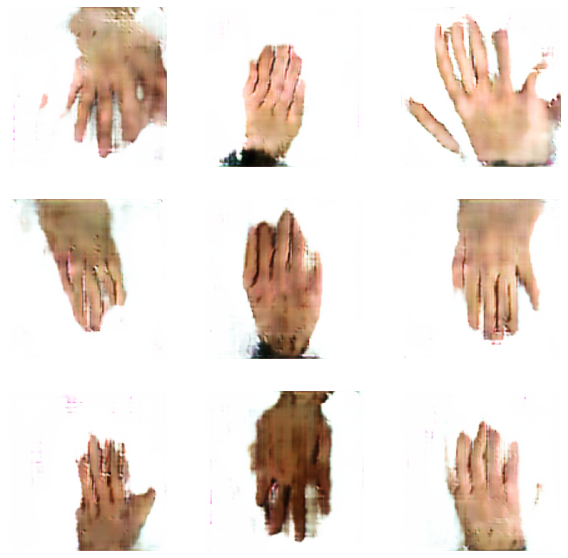

Time for epoch 1169 is 35.25630807876587 sec
................

In [0]:
last_trained_epoch = 1169
epochs_to_train = 500

train(real_generator, last_trained_epoch, epochs_to_train)

# Show the result

The next cells generate a gif with the generated images

In [5]:
anim_file = real_dir + '/hands_out.gif'

In [ ]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(out_images_path + '/image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
display.Image(filename=anim_file)

# Conclusion

The generated gif shows that the DCGAN is converging to realistig looking images of hands (no diminished gradient) without too much similarity of the generated images with different noise inputs (no mode collapse). 

It was really hard to balance the generator and discriminator in a way that the generator does not stagnate nor oscilate between the same images without producing mode collapse. There also aren't a lot of examples of how to train a GAN of images that are more complex than the ones from MNIST, and the existing ones are already outdated. Further, another drawback of training GANs is that to get an intuition about how well the model is doing, you first have to wait for about 100 epochs, which in my very low current processing power was taking about 2,5 hours.

# Possible improvements

* The generator model could use LeakyRELU & strides instead of RELU
* Optimize performance